In [40]:
import pandas as pd
import numpy as np



import os
import sys
import wave
import scipy
import scipy.io.wavfile as wav
import scipy.io.wavfile
from scipy.io.wavfile import read

from joblib import Parallel, delayed
import joblib
  
# librosa is a Python library for analyzing audio and music. It can be used to extract the data from the audio files.
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

import keras
from keras.callbacks import ReduceLROnPlateau #Reduce learning rate when a metric has stopped improving
from keras.models import Sequential  
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
from keras.utils import np_utils

from tensorflow.keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint #Callback to save the Keras model or model weights at some frequency

from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report,accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
# to play the audio files
from IPython.display import Audio



import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [2]:
os.mkdir('/kaggle/working/augmented/')

In [3]:
def trim_audio(path):
   
    # Read the wave file
    samplerate, data = read(path)

    # Taking amplitude values under absolute value of 50
    trimmed_file = data[np.absolute(data) > 50]


    # Writing Audio File to Given Folder
    scipy.io.wavfile.write("/kaggle/working/augmented/" + path.split('/')[-1], samplerate, trimmed_file)
    
def blank_audio(path):
    # Set the threshold for maximum amplitude
    THRESHOLD = 0.0001

    # Load the audio file
    audio, sr = librosa.load(path, sr=None)

    # Compute the maximum amplitude
    max_amplitude = max(abs(audio))

    # Check if the maximum amplitude is below the threshold
    if max_amplitude < THRESHOLD:
        return True
   


In [4]:
raw_audio="/kaggle/input/audio-dataset/"
raw_audio_directory_list = os.listdir(raw_audio)
for file in raw_audio_directory_list:
    file_path=raw_audio+file
    try:
        trim_audio(file_path)
    except:
        pass

In [5]:
audio="/kaggle/working/augmented/"
audio_directory_list = os.listdir(audio)

file_emotion = []
file_path = []

for file in audio_directory_list:
    # storing file paths
    file_path.append(audio + file)
    # storing file emotions
    part=file.split('_')
    p=part[1].split('.')
    name=p[0]
    if p[0] == 'sad':
        file_emotion.append('negative')
    elif p[0] == 'angry':
        file_emotion.append('negative')
    elif p[0] == 'happy':
        file_emotion.append('positive') 
    elif p[0] == 'neutral':
        file_emotion.append('neutral')
    else:
        file_emotion.append('Unknown')
        
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
audio_df = pd.concat([emotion_df, path_df], axis=1)
audio_df.head()

,Emotions,Path
0,negative,/kaggle/working/augmented/Aditya2S4_sad.wav
1,negative,/kaggle/working/augmented/J1S4_angry.wav
2,neutral,/kaggle/working/augmented/shreyas4s4_neutral.wav
3,negative,/kaggle/working/augmented/Ashutosh1S3_sad.wav
4,neutral,/kaggle/working/augmented/shreyas1s1_neutral.wav


In [6]:
bad_audio_files=[]
for path in audio_df.Path:
    if(blank_audio(path)):
        bad_audio_files.append(path)

    
audio_df = audio_df[~audio_df.Path.isin(bad_audio_files)]


In [7]:
audio_df.shape

(256, 2)

<AxesSubplot:xlabel='Emotions', ylabel='count'>

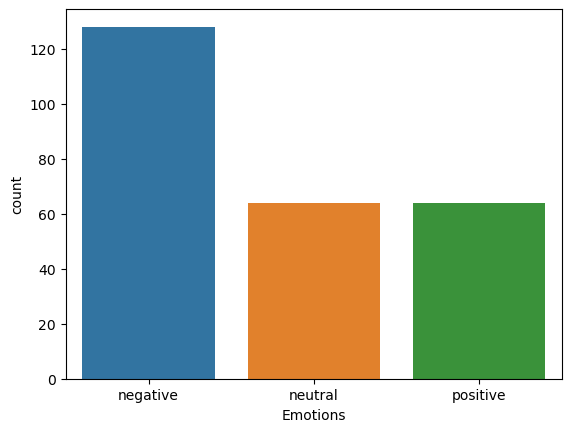

In [9]:
sns.countplot(x ='Emotions', data = audio_df)

In [10]:
def create_waveplot(data, sr, e):
    plt.figure(figsize=(10, 3))
    plt.title('Waveplot for audio with {} emotion'.format(e), size=15)
    librosa.display.waveshow(data, sr=sr)
   # plt.show()

def create_spectrogram(data, sr, e):
    # stft function converts the data into short term fourier transform
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(12, 3))
    plt.title('Spectrogram for audio with {} emotion'.format(e), size=15)
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')   
    #librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar()

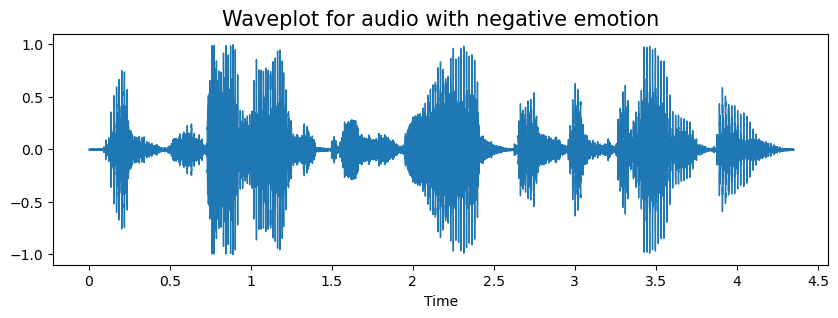

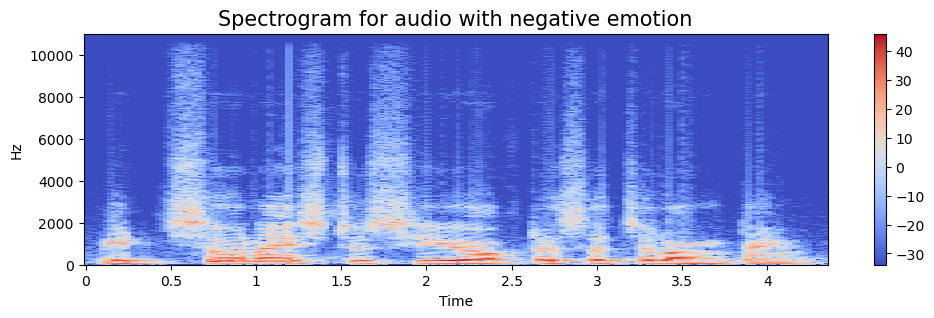

In [11]:
emotion='negative'
path = np.array(audio_df.Path[audio_df.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

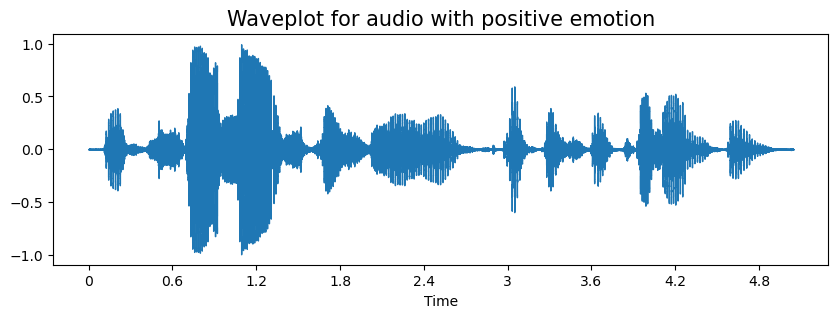

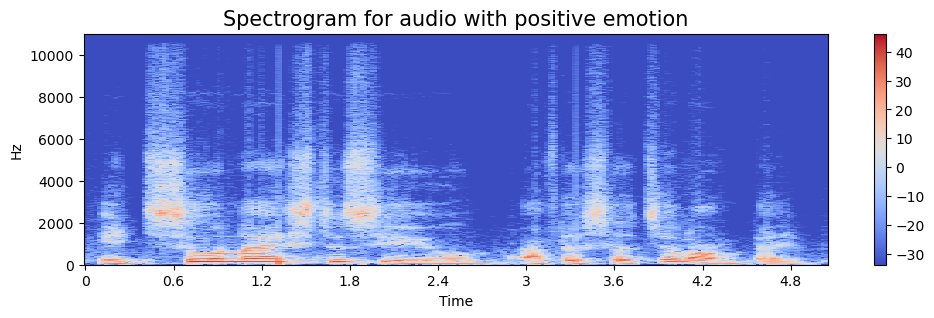

In [12]:
emotion='positive'
path = np.array(audio_df.Path[audio_df.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

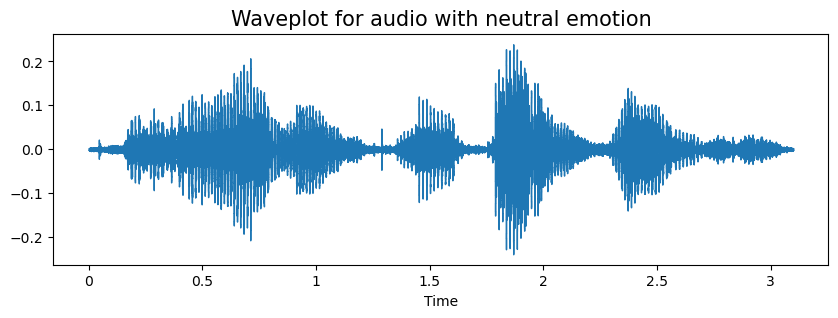

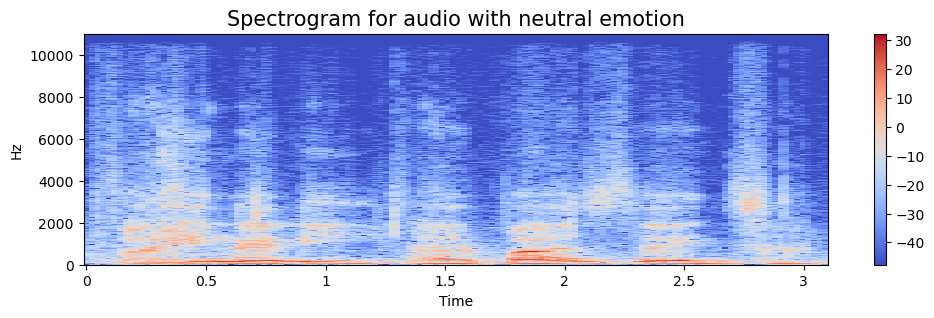

In [13]:
emotion='neutral'
path = np.array(audio_df.Path[audio_df.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

In [14]:
from pydub import AudioSegment
audio_directory_list = os.listdir(audio)
for file in audio_directory_list:
    nm=file.split('/')[-1]
    
    sound = AudioSegment.from_wav(audio+file)
    sound = sound.set_channels(1)
    sound.export("/kaggle/working/augmented/"+nm, format="wav")

In [15]:
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate)

def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)

def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sampling_rate, pitch_factor)





In [16]:
# taking any example and checking for techniques.
path = np.array(audio_df.Path)[100]
data, sample_rate = librosa.load(path)

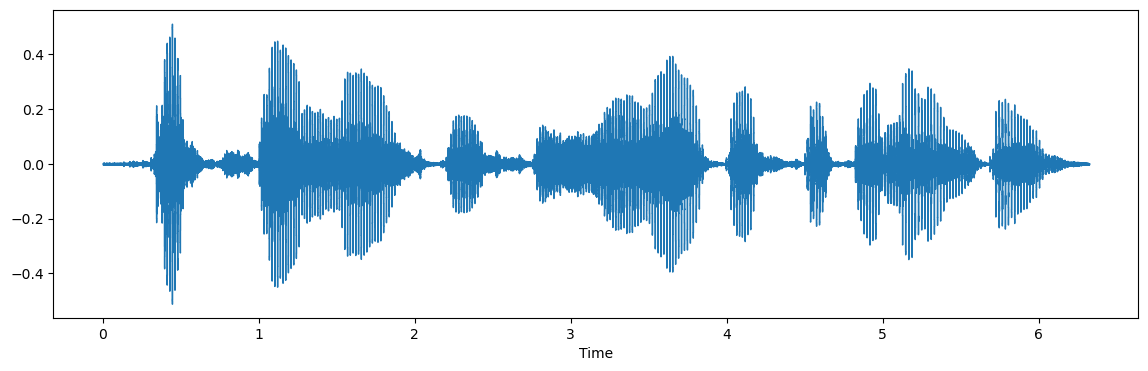

In [17]:
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=data, sr=sample_rate)
Audio(path)

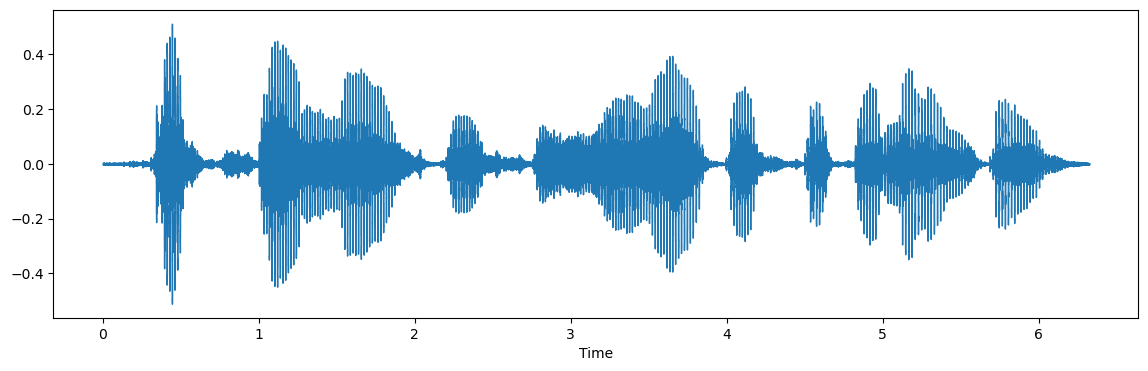

In [18]:
x = noise(data)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

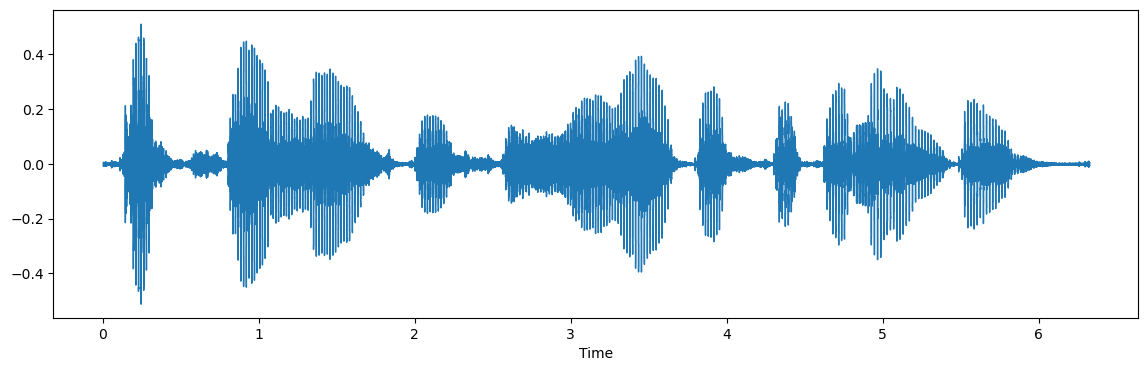

In [19]:
x = shift(data)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

In [20]:
def rep_matrix(path):
    # Load audio file
    with wave.open(path, "rb") as audio:
        # Get audio file parameters
        framerate = audio.getframerate()
        nframes = audio.getnframes()
        nchannels = audio.getnchannels()
        sampwidth = audio.getsampwidth()

        # Read audio frames
        frames = audio.readframes(nframes)

    # Convert frames to array of integers
    samples = np.frombuffer(frames, dtype=np.int16)

    # Reshape array into matrix with number of rows equal to number of channels
    samples_matrix = np.reshape(samples, (nframes, nchannels))

    # Print matrix
    print(samples_matrix)
rep_matrix(path)

[[-55]
 [-55]
 [-63]
 ...
 [ 52]
 [ 51]
 [ 51]]


In [21]:
def extract_features(data):
    # ZCR - The rate of sign-changes of the signal during the duration of a particular frame
    result = np.array([])
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    result=np.hstack((result, zcr)) # stacking horizontally

    # Chroma_stft -STFT represents information about the classification of pitch and signal structure
    stft = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
    result = np.hstack((result, chroma_stft)) # stacking horizontally

    # MFCC- Mel Frequency Cepstral Coefficients form a cepstral representation where the frequency bands are not linear but distributed according to the mel-scale
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mfcc)) # stacking horizontally

    # Root Mean Square Value
    rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
    result = np.hstack((result, rms)) # stacking horizontally

    # MelSpectogram
    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mel)) # stacking horizontally
    
    return result

def get_features(path):
    # duration and offset are used to take care of the no audio in start and the ending of each audio files as seen above.
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)
    
    # without augmentation
    res1 = extract_features(data)
    result = np.array(res1)
    
    # data with noise
    noise_data = noise(data)
    res2 = extract_features(noise_data)
    result = np.vstack((result, res2)) # stacking vertically
    
   
    return result

In [22]:
X, Y = [], []
for path, emotion in zip(audio_df.Path, audio_df.Emotions):
    feature = get_features(path)
    for ele in feature:
        X.append(ele)
        # appending emotion 3 times as we have made 3 augmentation techniques on each audio file.
        Y.append(emotion)

In [23]:
len(X), len(Y), audio_df.Path.shape

(512, 512, (256,))

In [24]:
Features = pd.DataFrame(X)
Features['labels'] = Y
Features.to_csv('features.csv', index=False)
Features.head()

,0,1,2,3,4,5,6,7,8,9,...,153,154,155,156,157,158,159,160,161,labels
0,0.041418,0.755679,0.694721,0.685153,0.640469,0.571039,0.565362,0.606921,0.597869,0.625931,...,0.000646,0.000560,0.000422,0.000402,0.000406,0.000336,0.000313,0.000179,3.980618e-05,negative
1,0.210856,0.791369,0.751103,0.755314,0.724806,0.699743,0.663582,0.638419,0.649991,0.704285,...,0.007258,0.008001,0.007972,0.007525,0.007754,0.007918,0.007397,0.007110,7.433830e-03,negative
2,0.067934,0.740612,0.644730,0.520427,0.502176,0.450464,0.458484,0.506919,0.538949,0.567580,...,0.000224,0.000239,0.000262,0.000199,0.000153,0.000122,0.000093,0.000049,4.254231e-06,negative
3,0.185140,0.818512,0.755454,0.655653,0.633095,0.588486,0.566922,0.584020,0.622211,0.659872,...,0.056203,0.051949,0.053846,0.053257,0.054589,0.056392,0.055125,0.055062,5.348172e-02,negative
4,0.033524,0.787719,0.669652,0.585964,0.586545,0.545380,0.464965,0.558374,0.674498,0.611738,...,0.000011,0.000010,0.000010,0.000009,0.000008,0.000007,0.000007,0.000004,4.310720e-07,neutral


In [25]:
X = Features.iloc[: ,:-1].values
Y = Features['labels'].values

In [26]:
X_train_, X_test_, y_train_, y_test_ = train_test_split(X, Y, test_size = 0.20)
# scaling our data with sklearn's Standard scaler
scaler = StandardScaler()
X_train_ = scaler.fit_transform(X_train_)
X_test_ = scaler.transform(X_test_)
X_train_.shape, y_train_.shape, X_test_.shape, y_test_.shape

((409, 162), (409,), (103, 162), (103,))

In [27]:
# Create a Logistic Regression object
logreg = LogisticRegression(random_state=0)

# Train the model using the training data
logreg.fit(X_train_, y_train_)

# Predict the labels of the test data using the trained model
y_pred_lr = logreg.predict(X_test_)

              precision    recall  f1-score   support

    negative       0.72      0.84      0.78        50
     neutral       0.63      0.46      0.53        26
    positive       0.88      0.85      0.87        27

    accuracy                           0.75       103
   macro avg       0.75      0.72      0.73       103
weighted avg       0.74      0.75      0.74       103

----accuracy score 74.75728155339806 ----


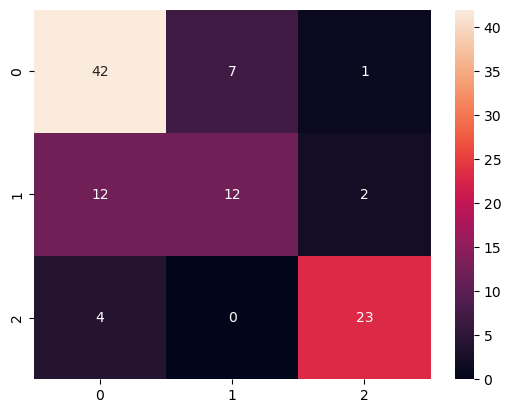

In [28]:
print(classification_report(y_test_,y_pred_lr))
acclr = float(accuracy_score(y_test_,y_pred_lr))*100
print("----accuracy score %s ----" % acclr)

cm_lr = confusion_matrix(y_test_,y_pred_lr)
df_lr = pd.DataFrame(cm_lr)
sns.heatmap(df_lr, annot=True, fmt='')
plt.show()

In [29]:
svclassifier = SVC(kernel = 'linear')
svclassifier.fit(X_train_, y_train_)
y_pred_svm = svclassifier.predict(X_test_)

              precision    recall  f1-score   support

    negative       0.71      0.88      0.79        50
     neutral       0.67      0.38      0.49        26
    positive       0.88      0.85      0.87        27

    accuracy                           0.75       103
   macro avg       0.75      0.71      0.71       103
weighted avg       0.74      0.75      0.73       103

----accuracy score 74.75728155339806 ----


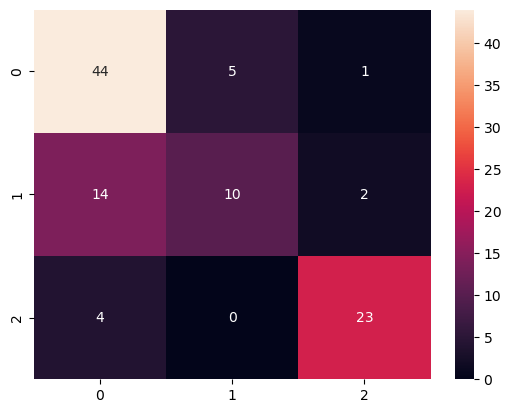

In [30]:
print(classification_report(y_test_,y_pred_svm))
accsvc = float(accuracy_score(y_test_,y_pred_svm))*100
print("----accuracy score %s ----" % accsvc)

cm = confusion_matrix(y_test_,y_pred_svm)
df_cm = pd.DataFrame(cm)
sns.heatmap(df_cm, annot=True, fmt='')
plt.show()

In [33]:
# Define the hyperparameters to tune
param_grid = {
    'max_depth': [5, 10, 15, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4, 8],
}

# Create a Decision Tree object
dt = DecisionTreeClassifier(random_state=0)

# Use GridSearchCV to tune hyperparameters
dt_grid = GridSearchCV(dt, param_grid, cv=5)
dt_grid.fit(X_train_, y_train_)

# Print the best hyperparameters found
print("Best hyperparameters:", dt_grid.best_params_)

# Train the model using the best hyperparameters
dt_best = DecisionTreeClassifier(**dt_grid.best_params_, random_state=0)
dt_best.fit(X_train_, y_train_)

# Predict the labels of the test data using the trained model
y_pred_dt = dt_best.predict(X_test_)

Best hyperparameters: {'max_depth': 15, 'min_samples_leaf': 1, 'min_samples_split': 2}


              precision    recall  f1-score   support

    negative       0.83      0.78      0.80        50
     neutral       0.65      0.77      0.70        26
    positive       0.84      0.78      0.81        27

    accuracy                           0.78       103
   macro avg       0.77      0.78      0.77       103
weighted avg       0.79      0.78      0.78       103

----accuracy score 77.66990291262135 ----


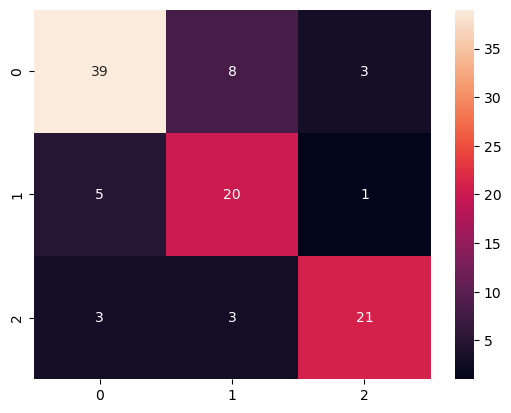

In [34]:
print(classification_report(y_test_,y_pred_dt))
accdt = float(accuracy_score(y_test_,y_pred_dt))*100
print("----accuracy score %s ----" % accdt)

cm_dt = confusion_matrix(y_test_,y_pred_dt)
df_cm_dt = pd.DataFrame(cm_dt)
sns.heatmap(df_cm_dt, annot=True, fmt='')
plt.show()

In [37]:
# Define the hyperparameters to tune
param_grid = {
    'n_estimators': [100, 150, 200],
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}

# Create a Random Forest object
rf = RandomForestClassifier(random_state=0)

# Use GridSearchCV to tune hyperparameters
rf_grid = GridSearchCV(rf, param_grid, cv=5)
rf_grid.fit(X_train_, y_train_)

# Print the best hyperparameters found
print("Best hyperparameters:", rf_grid.best_params_)

# Train the model using the best hyperparameters
rf_best = RandomForestClassifier(**rf_grid.best_params_, random_state=1)
rf_best.fit(X_train_, y_train_)

# Predict the labels of the test data using the trained model
y_pred_rf = rf_best.predict(X_test_)


Best hyperparameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 150}


In [38]:

rfclassifier = RandomForestClassifier(n_estimators = 150, random_state = 1) 
rfclassifier.fit(X_train_, y_train_)   

y_pred_rf = rfclassifier.predict(X_test_) 

              precision    recall  f1-score   support

    negative       0.88      1.00      0.93        50
     neutral       1.00      0.77      0.87        26
    positive       1.00      0.96      0.98        27

    accuracy                           0.93       103
   macro avg       0.96      0.91      0.93       103
weighted avg       0.94      0.93      0.93       103

----accuracy score 93.20388349514563 ----


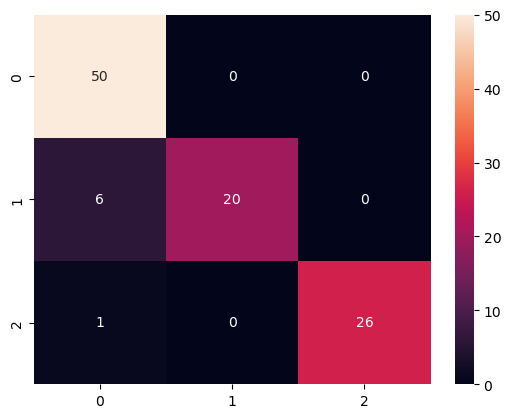

In [39]:
print(classification_report(y_test_,y_pred_rf))
accrf = float(accuracy_score(y_test_,y_pred_rf))*100
print("----accuracy score %s ----" % accrf)

cm_rf = confusion_matrix(y_test_,y_pred_rf)
df_cm_rf = pd.DataFrame(cm_rf)
sns.heatmap(df_cm_rf, annot=True, fmt='')
plt.show()

In [41]:
joblib.dump(rfclassifier, 'rfclassfier.pkl')

['rfclassfier.pkl']

In [42]:
# As this is a multiclass classification problem onehotencoding our Y.
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

# splitting data
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=0, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

# scaling our data with sklearn's Standard scaler
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

# making our data compatible to model.
x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((384, 162, 1), (384, 3), (128, 162, 1), (128, 3))

In [43]:
model = Sequential()
model.add(Conv1D(64, kernel_size=3, activation='relu', input_shape=(x_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(128, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(256, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(512, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 160, 64)           256       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 80, 64)           0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 78, 128)           24704     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 39, 128)          0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (None, 37, 256)           98560     
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 18, 256)          0

In [44]:
# Use ReduceLROnPlateau callback to reduce learningn rate if validation loss plateaus
rlrp = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=0.00001)

# Train the model with 50 epochs and batch size of 64
history = model.fit(x_train, y_train, batch_size=64, epochs=200, validation_data=(x_test, y_test), callbacks=[rlrp])


Epoch 1/200
6/6 [==============================] - 3s 183ms/step - loss: 1.0004 - accuracy: 0.5104 - val_loss: 0.9957 - val_accuracy: 0.4375 - lr: 0.0010
Epoch 2/200
6/6 [==============================] - 1s 132ms/step - loss: 0.9371 - accuracy: 0.5417 - val_loss: 0.9643 - val_accuracy: 0.4688 - lr: 0.0010
Epoch 3/200
6/6 [==============================] - 1s 127ms/step - loss: 0.8876 - accuracy: 0.5677 - val_loss: 0.9250 - val_accuracy: 0.4922 - lr: 0.0010
Epoch 4/200
6/6 [==============================] - 1s 130ms/step - loss: 0.8248 - accuracy: 0.5807 - val_loss: 0.8765 - val_accuracy: 0.4844 - lr: 0.0010
Epoch 5/200
6/6 [==============================] - 1s 136ms/step - loss: 0.7766 - accuracy: 0.5833 - val_loss: 0.8799 - val_accuracy: 0.4922 - lr: 0.0010
Epoch 6/200
6/6 [==============================] - 1s 127ms/step - loss: 0.7001 - accuracy: 0.6380 - val_loss: 0.7776 - val_accuracy: 0.6328 - lr: 0.0010
Epoch 7/200
6/6 [==============================] - 1s 131ms/step - loss: 0.6

4/4 [==============================] - 0s 15ms/step - loss: 0.3542 - accuracy: 0.8672
Accuracy of our model on test data :  86.71875 %


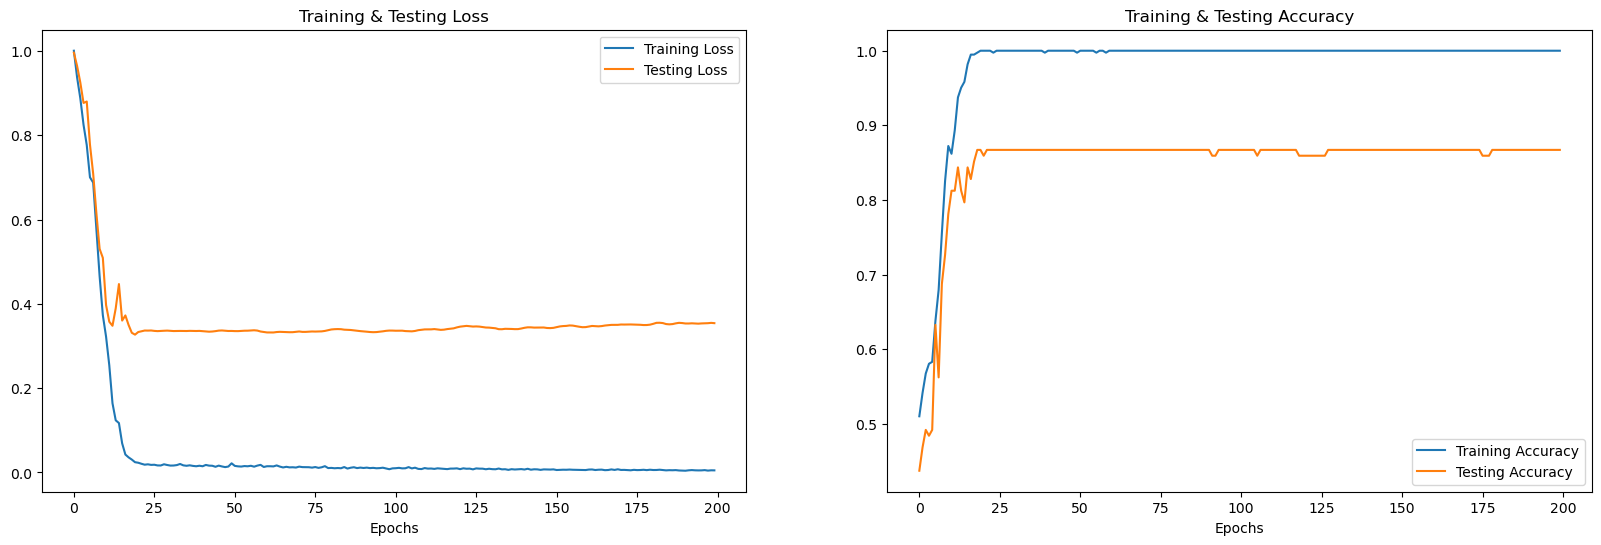

In [45]:
print("Accuracy of our model on test data : " , model.evaluate(x_test,y_test)[1]*100 , "%")

epochs = [i for i in range(200)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

In [46]:
# predicting on test data.
pred_test = model.predict(x_test)
y_pred = encoder.inverse_transform(pred_test)

y_test = encoder.inverse_transform(y_test)

4/4 [==============================] - 0s 14ms/step


In [47]:
df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred.flatten()
df['Actual Labels'] = y_test.flatten()

df.head(10)

,Predicted Labels,Actual Labels
0,neutral,negative
1,negative,negative
2,negative,negative
3,negative,neutral
4,positive,positive
5,positive,positive
6,neutral,neutral
7,negative,neutral
8,neutral,neutral
9,negative,negative


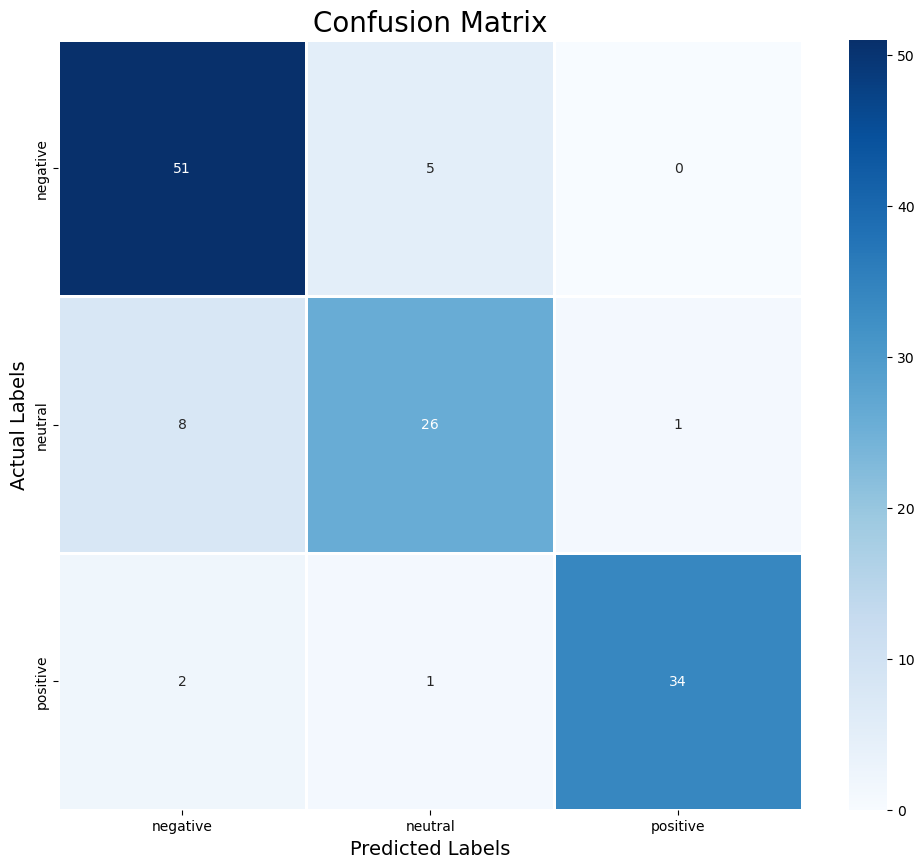

In [48]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

In [49]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

    negative       0.84      0.91      0.87        56
     neutral       0.81      0.74      0.78        35
    positive       0.97      0.92      0.94        37

    accuracy                           0.87       128
   macro avg       0.87      0.86      0.86       128
weighted avg       0.87      0.87      0.87       128

